This notebook discusses how explicit automata (the `spot::twa_graph_ptr` objects in C++) are stored by Spot.  The Python bindings do not expose all of the internals available in C++, however they have some graphical representation that are convenient to present those inner workings.

In [1]:
import buddy
import spot
spot.setup(show_default='.n')
from IPython.display import display

# The two-vector representation

Let's consider a small automaton, generated from an LTL formula.

In [2]:
aut = spot.translate('GF(a <-> Xa) & FGb', 'det', 'gen')

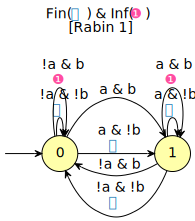

In [3]:
aut

The graphical representation above is just a convenient representation of that automaton and hides some details.  Internally, this automaton is stored as two vectors plus some additional data.  All of those can be displayed using the `show_storage()` method.  The two vectors are the `states` and `edges` vectors.  The additional data gives the initial state, number of acceptance sets, acceptance condition, list of atomic propositions, as well as a bunch of [property flags](https://spot.lrde.epita.fr/concepts.html#property-flags) on the automaton.  All those properties default to `maybe`, but some algorithms will turn them to `yes` or `no` whenever that property can be decided at very low cost (usually a side effect of the algorithm).  In this example we asked for a deterministic automaton, so the output of the construction is necessarily `universal` (this means no existantial branching, hence deterministic for our purpose), and this property implies `unambiguous` and `semi_deterministic`.

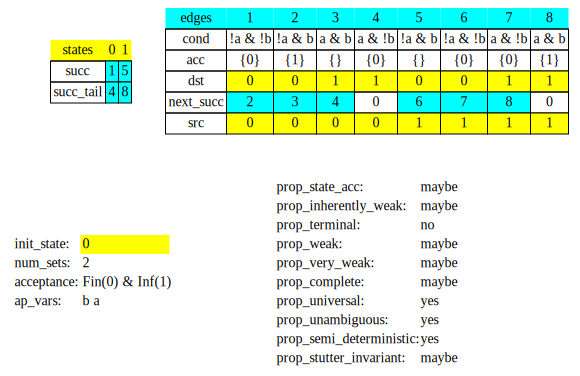

In [4]:
aut.show_storage()

Each state is represented by an integer that is a 0-based index into the `states` array.  Each edge is also represented by an integer that is a 1-based index into the `edges` array.  In the above picture, yellow and cyan denote state and edge indices respectively.

Adding a new edge, for instance, will augment the size of the `edges` array and return the index of the newly added edge:

In [5]:
s = aut.new_state()
aut.set_init_state(s)
aut.new_edge(s, 0, buddy.bddtrue)

9

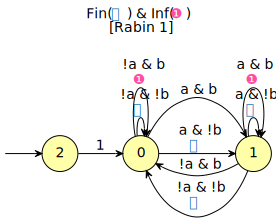

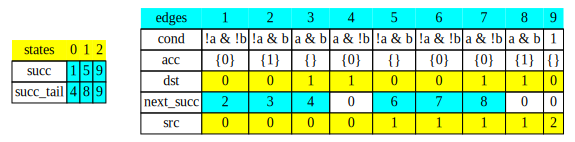

In [6]:
display(aut, aut.show_storage("v"))  # "v" displays only the states and edges Vectors

For each state, the `states` vector stores two edge indices: `succ` is the index of the first outgoing edge, and `succ_tail` is the index of the last outgoing edge.  Since there is no edge at index `0`, that value is used to indicate that there is no outgoing edge.

In the `edges` vector, the field `next_succ` is used to organize the outgoing edges of a state as a linked list.  For instance to iterate over all successors of state `0`, we would start at the edge `e = states[0].succ` (if it's not `0`),
then move to the next successor with `e = edges[e].next_succ`, and repeat until `e` becomes `0`.  This code cannot be executed in Python because the automaton class won't let us access the `states` vector.  However this iteration mechanism is what is used into the `out()` method: `out()` simply provides an iterator over some columns of the `edges` vector, following the `next_succ` links.  When we have a reference to a column of `edges` as returned by `out()`, we can convert it into an edge index with the `edge_number()` method.

In [7]:
for ed in aut.out(0):
    print("edges[{e}].src={src}, edges[{e}].dst={dst}".format(e=aut.edge_number(ed), src=ed.src, dst=ed.dst))

edges[1].src=0, edges[1].dst=0
edges[2].src=0, edges[2].dst=0
edges[3].src=0, edges[3].dst=1
edges[4].src=0, edges[4].dst=1


The other fields of the `edges` vector probably speak for themselves. `cond` is a BDD representing the boolean combination of atomic propositions expected by the edge, `acc` is an instance of `spot::acc_cond::mark_t`, i.e., a bit set representing the set of acceptance sets the edge belongs to, `src` and `dst` are the source and destination of the transition.  Of course when iterating over the successors of a state with `aut.out(src)`, the source is well known, but there are other situations where it is convenient to retrieve the source from the edge (e.g., when iterating over all edges of an automaton, or when storing edges indices for later processing).

You can access one column of the `edges` vector using the `edge_storage()` method.  For instance let's modify edge 3:

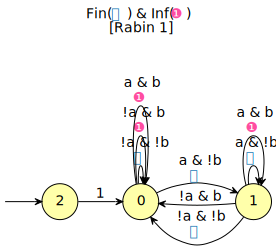

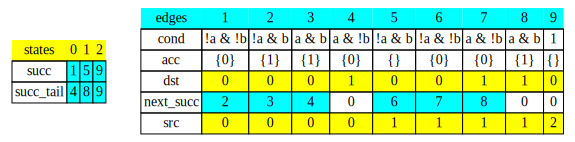

In [8]:
aut.edge_storage(3).acc.set(1)
aut.edge_storage(3).dst = 0
display(aut)
aut.show_storage("v")

Having the source into the `edges` vector also allows us to easily sort that vector to put all sibling transitions (i.e., transition leaving the same state) together to improve data locality.  The `merge_edges()` method will do that and a bit more: edges are first sorted by (`src`, `dst`, `acc`) making possible to merge the `cond` field of edges with identical (`src`, `dst`, `acc`).  On Fin-less automata (not our example), the a second pass is perform to sort the edge (`src`, `dst`, `cond`) and then merge the `acc` fields of edges that share the other fields.

In our example, `merge_edges()` will merge edges 1 and 3.

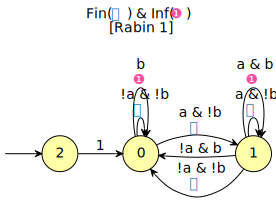

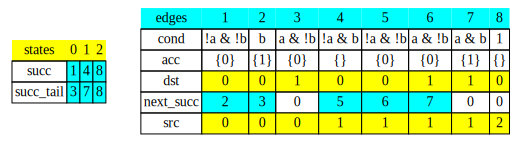

In [9]:
aut.merge_edges()
display(aut, aut.show_storage("v"))

Note that the `succ_tail` field of the `states` vector is seldom used when reading automata as the linked list of edges ends when `next_succ` (or `succ`) equals `0`.  Its main use is during calls to `new_edge()`: new edges are always created at the end of the list (otherwise it would be hard to preserve the order of edges when parsing and automaton and printing it).

# The property-update issue

Properties like `prop_complete()`, `prop_universal()`, and the like are normally updated by algorithms that modify the automaton in place.  They are not updated when we modify the automaton using low-level methods like `new_state()` or `new_edges()` as we have done so far.

For instance we could add a new edge to the automaton to introduce some non-determinism, and the automaton would still pretend it is universal.

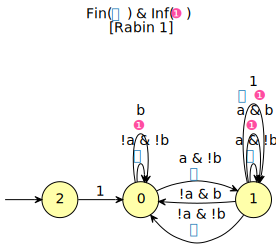

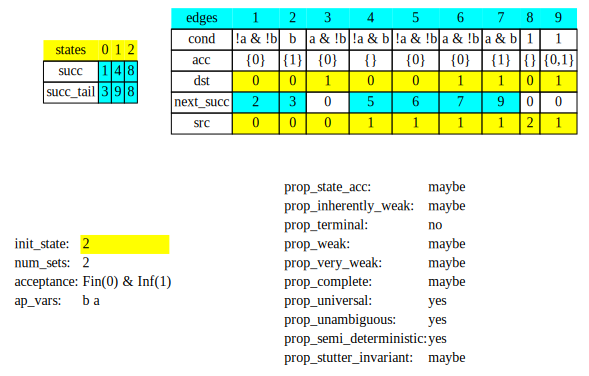

In [10]:
aut.new_edge(1, 1, buddy.bddtrue, [1, 0])
display(aut, aut.show_storage())

Such an inconsistency will cause many issues when the automaton is passed to algorithm with specialized handling of universal automata.  When writing an algorithm that modify the automaton, it is your responsibility to update the property bits as well.  In this case it could be fixed by calling `aut.prop_universal(False); aut.prop_unambiguous(spot.trival_maybe()); ...` for each property, or by reseting all properties to `maybe` with `prop_reset()`:

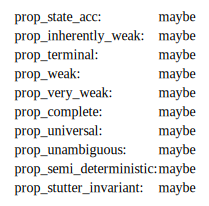

In [11]:
aut.prop_reset()
aut.show_storage("p")  # "p" displays only the properties

# Erasing edges

Erasing a single edge, denoted by its edge index `i`, is not convenient because of the linked structure of the edges: the `next_succ` of the previous (but unknown given `i`) edge would have to be updated (or maybe the `succ` or `succ_tail` fields of `states` vector have to be updated).

The `out_iteraser(s)` method provides a way to iterate over the outgoing edges of state `s` that allows erasing edges.  The iteration does not follow the usual Python pattern because once you have looked at the current edge using `current()`, you have two choices: `advance()` to the next one, or `erase()` the current one (and advance to the next). Note that `it.current()` and `it.advance()` are written `*it` and `++it` in C++.

The following example erases all the outgoing transitions of state `0` that belong to acceptance set `1`.

In [12]:
it = aut.out_iteraser(0)
while it:
    e = it.current()
    toerase = e.acc.has(1)
    print("pos={}, acc={}, toerase={}".format(aut.edge_number(e), e.acc, toerase))
    if toerase:
        it.erase()
    else:
        it.advance()

pos=1, acc={0}, toerase=False
pos=2, acc={1}, toerase=True
pos=3, acc={0}, toerase=False


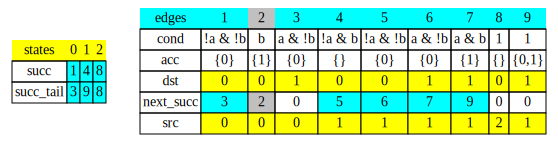

In [13]:
aut.show_storage("v")

Notice that the edges vector hasn't been resized, as doing so would renumber edges.  Instead, erased edges have removed from the linked list of outgoing edges of `0`, and their `next_succ` field has been changed to point to themselves. 

You can test whether an edges has been erased with `is_dead_edge()`:

In [14]:
aut.is_dead_edge(2)

True

However you usually do not have to care, because iterator methods will skip such dead edges.  For instance:

In [15]:
for e in aut.edges():  # iterate over all non-erased edges
    print("edges[{e}].src={src}, edges[{e}].dst={dst}".format(e=aut.edge_number(e), src=e.src, dst=e.dst))

edges[1].src=0, edges[1].dst=0
edges[3].src=0, edges[3].dst=1
edges[4].src=1, edges[4].dst=0
edges[5].src=1, edges[5].dst=0
edges[6].src=1, edges[6].dst=1
edges[7].src=1, edges[7].dst=1
edges[8].src=2, edges[8].dst=0
edges[9].src=1, edges[9].dst=1


Similarly, `num_edges()` returns the count of non-erased edges.

In [16]:
aut.num_edges()

8

Erased edges are actually removed by `merge_edges()`:

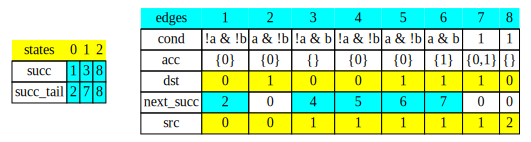

In [17]:
aut.merge_edges()
aut.show_storage("v")

Another way to erase an edge, is to set its `cond` field to `bddfalse`.  Strictly speaking, this does not really erase the edge, and it will still be iterated upon.  However a subsequent call to `merge_edges()` will perform the removal of that edge.

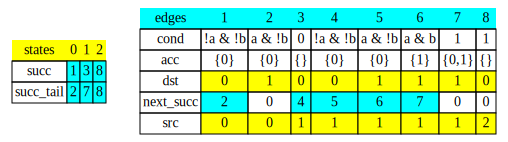

In [18]:
aut.edge_storage(3).cond = buddy.bddfalse
aut.show_storage("v")

In [19]:
for e in aut.edges():  # iterate over all non-erased edges
    print("edges[{e}].src={src}, edges[{e}].dst={dst}".format(e=aut.edge_number(e), src=e.src, dst=e.dst))

edges[1].src=0, edges[1].dst=0
edges[2].src=0, edges[2].dst=1
edges[3].src=1, edges[3].dst=0
edges[4].src=1, edges[4].dst=0
edges[5].src=1, edges[5].dst=1
edges[6].src=1, edges[6].dst=1
edges[7].src=1, edges[7].dst=1
edges[8].src=2, edges[8].dst=0


In [20]:
aut.is_dead_edge(3)

False

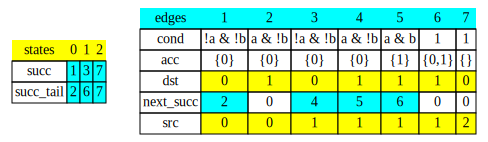

In [21]:
aut.merge_edges()
aut.show_storage("v")

# Alternation

The data structures seen so far only support a single destination per edge.  Support for universal branching therefore calls for something new.

Let's add some universal branching in our example automaton.

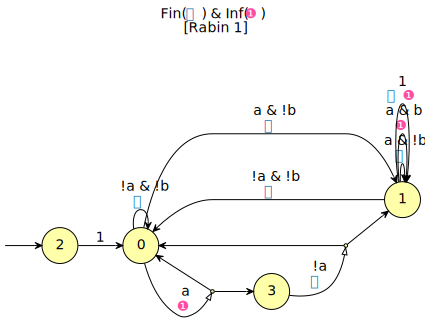

In [22]:
a = buddy.bdd_ithvar(aut.register_ap('a'))
s = aut.new_state()
aut.new_univ_edge(0, [0, s], a, [1])
aut.new_univ_edge(s, [0, 1], -a, [0])
aut

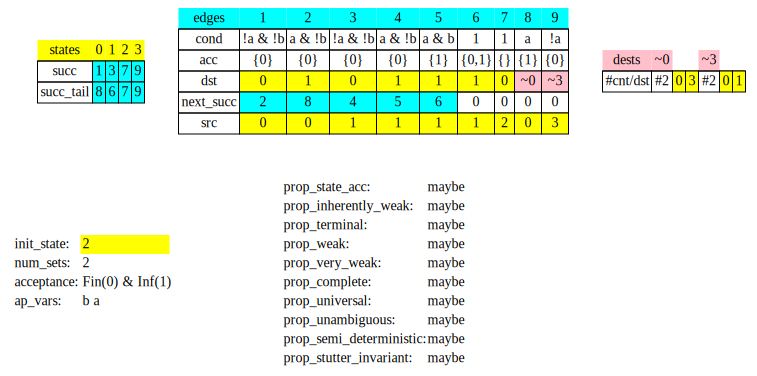

In [23]:
aut.show_storage()

Here we have created two universal transitions: `0->[0,2]` and `2->[0,1]`.  The destination groups `[0,2]` and `[0,1]`  are stored in a integer vector called `dests`.  Each group is encoded by its size immediately followed by the state numbers of the destinations.  So group `[0,2]` get encoded as `2,0,2` at position `0` of `dests`, and group `[0,1]` is encoded as `2,0,1` at position `3`.  Each group is denoted by the index of its size in the `dests` vector.  When an edge targets a destination group, the complement of that destination index is written in the `dst` field of the `edges` entry, hence that `~0` and `~3` that appear here.  Using a complement like this allows us to quickly detect universal edges by looking at the sign bit if their `dst` entry.

To work on alternating automata, one can no longuer just blindingly use the `dst` field of outgoing iterations:

In [24]:
for e in aut.edges():
    print(e.dst)

0
1
0
1
1
1
0
4294967295
4294967292


Using such a large `e.dst` value as an index in `states` would likely crash the program.  Instead we should iterate over all the successor of an edge using the `univ_dests()` method.  Note that `univ_dests()` can be applied to regular edges as well.

In [25]:
for e in aut.edges():
    print([d for d in aut.univ_dests(e.dst)])

[0]
[1]
[0]
[1]
[1]
[1]
[0]
[0, 3]
[0, 1]


Note that `univ_dests()` can be applied to `e.dst` or `e`.

In [26]:
for e in aut.edges():
    print([d for d in aut.univ_dests(e)])

[0]
[1]
[0]
[1]
[1]
[1]
[0]
[0, 3]
[0, 1]


Note that the initial state get also use universal branching:

In [27]:
aut.set_univ_init_state([0, 1, 2])

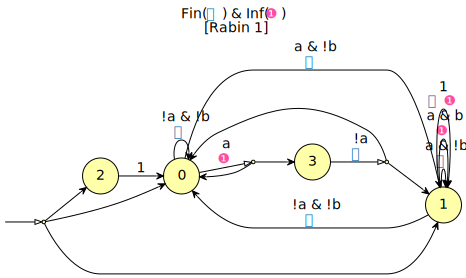

In [28]:
aut

In [29]:
print([d for d in aut.univ_dests(aut.get_init_state_number())])

[0, 1, 2]


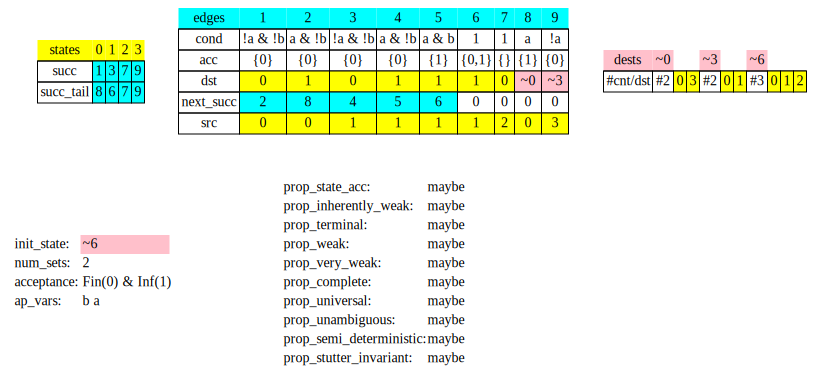

In [30]:
aut.show_storage()

Adding several transitions with the same destination groups may result in duplicates in the `dests` vector.   Those groups get merged during `merge_edges()`.

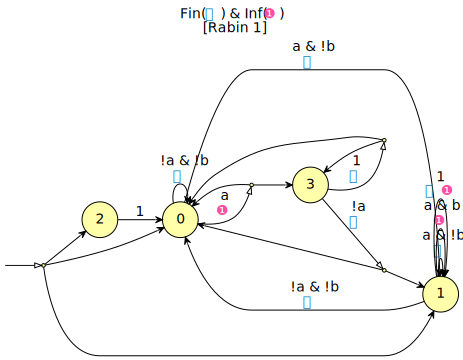

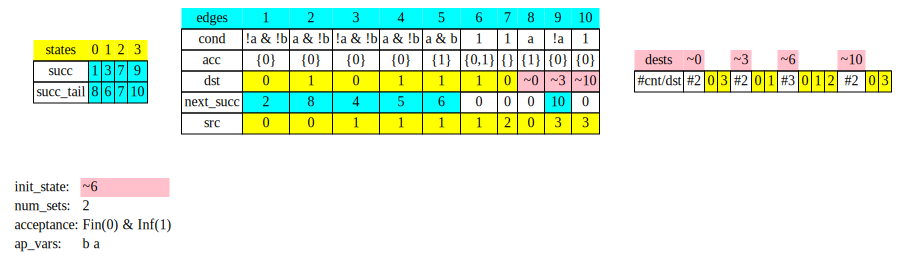

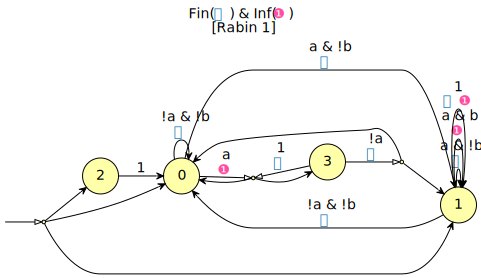

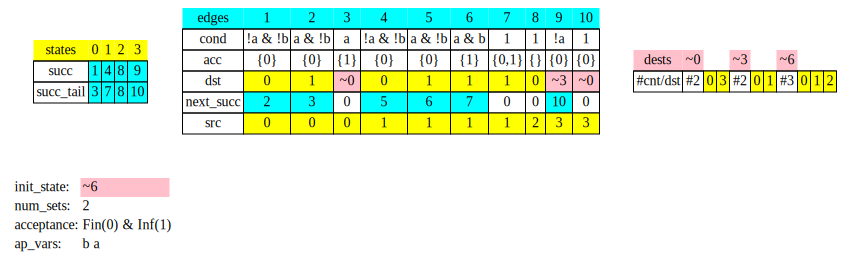

In [31]:
aut.new_univ_edge(3, [0,3], buddy.bddtrue, [0])
display(aut, aut.show_storage("vd"))
aut.merge_edges()
display(aut, aut.show_storage("vd"))

Above group `~0` and `~10` have been merged.

# Named properties

Finally automata can also been attached [arbitrarily named properties](https://spot.lrde.epita.fr/concepts.html#named-properties).  The `show_storage()` method will only display the name of these properties, not their contents.  Properties like `automaton-name` are used to store a name for the automaton, `product-states` is filled by `product()` and holds a vector of pairs representing the source states in the product's operands, etc.

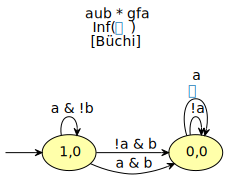

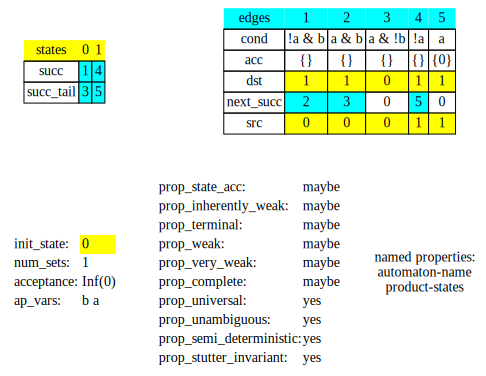

In [32]:
aub = spot.translate('a U b')
gfa = spot.translate('GFa')
prod = spot.product(aub, gfa)
prod.set_name("aub * gfa")
display(prod, prod.show_storage())

These properties also need to be updated by algorithms.  They can be reset with:

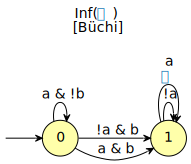

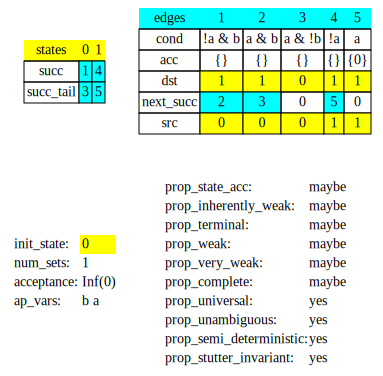

In [33]:
prod.release_named_properties()
display(prod, prod.show_storage())